<a href="https://colab.research.google.com/github/KiarashVaziri/E4-Data-Analysis/blob/main/IBI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estimation of BP based on IBI
Downsample IBI to around the dimension of tags or consider a window at the time you are given BP to get Ys, extract some simple features (mean, std, entropy) to get X, do a regression of to map Ys = beta . X + b0, look at the goodness of fitness

# Packages

In [ ]:
#%% PACKAGES
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import butter, filtfilt, lfilter, iirnotch, resample
from scipy.stats import pearsonr 
# plt.rcParams['figure.figsize'] = [12, 6]
# plt.rcParams.update({'font.size':15})

# Load Data

In [ ]:
!pwd
#%cd /content/drive/MyDrive/Colab\ Notebooks/DMCBH/OH02
%cd /content/drive/MyDrive/Colab\ Notebooks/PPRC/DATA
!pwd

/content
/content/drive/MyDrive/Colab Notebooks/PPRC/DATA
/content/drive/MyDrive/Colab Notebooks/PPRC/DATA


In [ ]:
# import OS module
import os

# Get the list of all files and directories
path = "."
dir_list = os.listdir(path)
dir_list.remove('Tables')
dir_list = np.sort(dir_list)
dir_list

array(['OH01_April 14 2022_e4 data', 'OH02_April 19 2022_e4 data',
       'OH03_April 20 2022_e4 data', 'OH04_April 22 2022_e4 data',
       'OH05_April 22 2022_e4 data', 'OH06_', 'OH07_May 3 2022_e4 data',
       'OH08_May 4 2022_e4 data', 'OH09_May 5 2022_e4 data',
       'OH10_May 10 2022_e4 data', 'OH11_May 16 2022_e4 data',
       'OH12_May 17 2022_e4 data', 'OH13_May 18 2022_e4 data',
       'OH14_May 19 2022_e4 data', 'OH15_May 25 2022_e4 data',
       'OH16_May 27 2022_e4 data', 'OH17_May 30 2022_e4 data',
       'OH18_June 1 2022_e4 data', 'OH19_June_8_2022_e4 data',
       'OH20_June_8_2022_e4 data', 'OH21_June_9_2022_e4 data',
       'OH22_June_10_2022_e4 data', 'OH23_June_13_2022_e4 data',
       'OH24_June_14_2022_e4 data', 'data.csv'], dtype='<U26')

In [ ]:
#%% LOAD DATA

# patient = "OH02"
# DIR = "OH02_April 19 2022_e4 data"

patient_no = 2
DIR = dir_list[patient_no-1]

# LOAD TABLE
df_bp = pd.read_csv("Tables/Table_OH"+"{0:0=2d}".format(patient_no)+".csv")
sbp = df_bp['SBP']
dbp = df_bp['DBP']
hr = df_bp['HR']
print(df_bp.head())

# READ INTER BEAT INTERVALs 
df_ibi = pd.read_csv(DIR+"/IBI.csv")
init_time, _ = df_ibi.keys()
df_ibi.rename(columns={init_time:"timings", " IBI":"ibi"}, inplace=True)
init_time = float(init_time)
fs_bvp = 64
df_ibi.head()

   SBP  DBP  HR
0  131   77  53
1  128   75  52
2  130   74  52
3  104   65  66
4  112   66  66


,timings,ibi
0,12.921875,0.984375
1,13.921875,1.000000
2,14.953125,1.031250
3,15.968750,1.015625
4,34.640625,1.015625


# Regression

In [ ]:
if patient_no == 2:
  all_ = [i for i in range(1, 39+1)]
  lying_1 = np.array([1, 2, 3, 6, 7, 8, 11, 12, 13])
  lying_2 = lying_1 + 18
  lying = np.concatenate((lying_1, lying_2))
  standing = np.array([x for x in all_ if x not in lying])
elif patient_no == 15:
  all_ = [i for i in range(1, 40+1)]
  lying_1 = np.array([1, 2, 3, 6, 7, 8, 11, 12, 13])
  lying_2 = lying_1 + 18
  lying = np.concatenate((lying_1, lying_2))
  standing = np.array([x for x in all_ if x not in lying])
else:
  all_ = [i for i in range(1, 42+1)]
  lying_1 = np.array([1, 2, 3, 6, 7, 8, 11, 12, 13])
  lying_2 = lying_1 + 21
  lying = np.concatenate((lying_1, lying_2))
  standing = np.array([x for x in all_ if x not in lying])

lying, standing

(array([ 1,  2,  3,  6,  7,  8, 11, 12, 13, 19, 20, 21, 24, 25, 26, 29, 30,
        31]),
 array([ 4,  5,  9, 10, 14, 15, 16, 17, 18, 22, 23, 27, 28, 32, 33, 34, 35,
        36, 37, 38, 39]))

In [ ]:
cols =['mean', 'var', 'sbp', 'dbp', 'hr']
data = pd.DataFrame(columns=cols)

#FIND TAGS
df = pd.read_csv(DIR+"/tags.csv", header=None)
tags = np.array(df)
delay = 40  # in seconds
taps = [float(tags[i]-init_time) + delay for i in range(len(tags))]

margin = 30
mu_list = []
var_list = []

for time_ in taps:
  points = np.abs(df_ibi['timings'] - time_)  <= margin
  mu = np.mean(df_ibi['ibi'][points])
  var = np.var(df_ibi['ibi'][points])

  mu_list.append(mu)
  var_list.append(var)

states = []
for i in range(1, len(taps)+1):
  if i in lying:
    states.append(0)
  else:
    states.append(1)

data['mean'] = mu_list
data['var'] = var_list
data['sbp'] = sbp
data['dbp'] = dbp
data['hr'] = hr
data['state'] = states
print(data)
data = data.dropna()
data

        mean       var  sbp  dbp  hr  state
0   1.140000  0.000771  131   77  53      0
1   1.139946  0.000329  128   75  52      0
2   1.133929  0.001013  130   74  52      0
3   0.859375  0.004150  104   65  66      1
4   0.937500  0.000000  112   66  66      1
5   1.230625  0.001880  134   76  50      0
6   1.193287  0.000762  135   76  50      0
7   1.185156  0.002912  136   70  51      0
8   0.916667  0.000217  103   66  67      1
9        NaN       NaN   97   73  67      1
10  1.226273  0.004311  135   77  51      0
11  1.199728  0.000424  134   76  50      0
12  1.172619  0.001220  131   71  50      0
13  0.932292  0.000054  106   66  68      1
14  0.980469  0.010788  109   66  65      1
15       NaN       NaN  105   63  64      1
16  0.935268  0.000518  102   65  65      1
17  0.703125  0.000000  102   66  66      1
18  1.183105  0.001941  129   76  51      0
19  1.205529  0.006905  129   74  51      0
20  1.174716  0.000968  129   76  52      0
21  0.919034  0.001679  110   66

,mean,var,sbp,dbp,hr,state
0,1.140000,0.000771,131,77,53,0
1,1.139946,0.000329,128,75,52,0
2,1.133929,0.001013,130,74,52,0
3,0.859375,0.004150,104,65,66,1
4,0.937500,0.000000,112,66,66,1
5,1.230625,0.001880,134,76,50,0
6,1.193287,0.000762,135,76,50,0
7,1.185156,0.002912,136,70,51,0
8,0.916667,0.000217,103,66,67,1
10,1.226273,0.004311,135,77,51,0


Score of linear regression for diastolic blood pressure: 0.784


(27.06687463332964, 42.8224746087119)

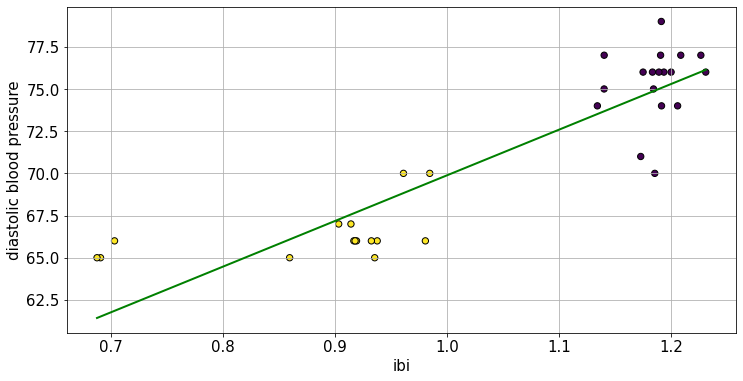

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression as lr
from sklearn.model_selection import train_test_split

input = ['mean']
X_ = np.array(data[input])
target = np.array(data['dbp'], dtype=np.float32)
X_train, X_test, y_train, y_test = train_test_split(X_, target, test_size=0.30, shuffle=True)


clf = LinearRegression()
#clf = lr()
clf.fit(X_train, y_train)
score_dbp = clf.score(X_test, y_test)
print(f"Score of linear regression for diastolic blood pressure: {score_dbp:.3f}")

# Add sample points
colors = data['state']
plt.scatter(X_.reshape(-1), target, c = colors, s=40, edgecolors="k")
plt.xlabel("ibi")
plt.ylabel("diastolic blood pressure")

# Find the best fit linear regression
b, a = np.polyfit(X_train.reshape(-1), y_train, deg=1)
xseq = np.linspace(min(X_), max(X_), num=100)
plt.plot(xseq, a + b * xseq, color="green", lw=2);
plt.grid()
b, a

Score of linear regression for systolic blood pressure: 0.811


(61.29588318653649, 57.421247368088615)

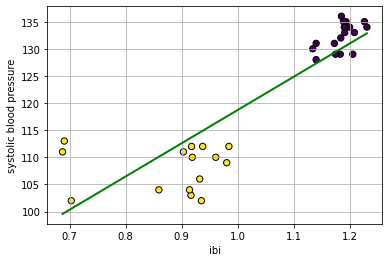

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

input = ['mean']
X_ = np.array(data[input])
target = np.array(data['sbp'], dtype=np.float32)
X_train, X_test, y_train, y_test = train_test_split(X_, target, test_size=0.20, shuffle=True)


clf = LinearRegression()
clf.fit(X_train, y_train)
score_sbp = clf.score(X_test, y_test)
print(f"Score of linear regression for systolic blood pressure: {score_sbp:.3f}")

# Add sample points
colors = data['state']
plt.scatter(X_.reshape(-1), target, c=colors, s=40, edgecolors="k")
plt.xlabel("ibi")
plt.ylabel("systolic blood pressure")

# Find the best fit linear regression
b, a = np.polyfit(X_train.reshape(-1), y_train, deg=1)
xseq = np.linspace(min(X_), max(X_), num=100)
plt.plot(xseq, a + b * xseq, color="green", lw=2);
plt.grid()
b, a

Score of linear regression for heart-rate: 0.796


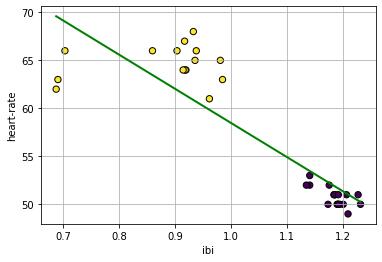

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

input = ['mean']
X_ = np.array(data[input])
target = np.array(data['hr'])
X_train, X_test, y_train, y_test = train_test_split(X_, target, test_size=0.20, shuffle=True)


clf = LinearRegression()
clf.fit(X_train, y_train)
score_hr = clf.score(X_test, y_test)
print(f"Score of linear regression for heart-rate: {score_hr:.3f}")

# Add sample points
colors = data['state']
plt.scatter(X_.reshape(-1), target, c=colors, s=40, edgecolors="k")
plt.xlabel("ibi")
plt.ylabel("heart-rate")

# Find the best fit linear regression
b, a = np.polyfit(X_train.reshape(-1), y_train, deg=1)
xseq = np.linspace(min(X_), max(X_), num=100)
plt.plot(xseq, a + b * xseq, color="green", lw=2);
plt.grid()

In [ ]:
a, b

(94.09952429204661, -35.63971449349215)

In [ ]:
from scipy import stats

input = ['mean']
X = np.array(data[input])
target = np.array(data['dbp'])
X_train, X_test, y_train, y_test = train_test_split(X_, target, test_size=0.20, shuffle=True)

y = target
lm = LinearRegression()
lm.fit(X,y)
params = np.append(lm.intercept_,lm.coef_)
predictions = lm.predict(X)

#newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
#MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

# Note if you don't want to use a DataFrame replace the two lines above with
newX = np.append(np.ones((len(X),1)), X, axis=1)
MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

myDF3 = pd.DataFrame()
myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilities"] = [params,sd_b,ts_b,p_values]
print(myDF3)

   Coefficients  Standard Errors  t values  Probabilities
0       44.2253            2.553    17.322            0.0
1       25.8110            2.406    10.726            0.0


In [ ]:
lying_data = data[data['state'] == 0] # state = 0 represents lying
standing_data = data[data['state'] == 1] # state = 1 represents standing
df_stats = pd.DataFrame(columns = ['t-value', 'p-value'], index = ['dbp (Omron)', 'sbp (Omron)', 'hr (Omron)', 'estimated hr (E4)'])
df_stats['t-value']['dbp (Omron)'], df_stats['p-value']['dbp (Omron)'] = stats.ttest_ind(lying_data['dbp'], standing_data['dbp'])
df_stats['t-value']['sbp (Omron)'], df_stats['p-value']['sbp (Omron)'] = stats.ttest_ind(lying_data['sbp'].astype(float), standing_data['sbp'].astype(float))
df_stats['t-value']['hr (Omron)'], df_stats['p-value']['hr (Omron)'] = stats.ttest_ind(lying_data['hr'], standing_data['hr'])
df_stats['t-value']['estimated hr (E4)'], df_stats['p-value']['estimated hr (E4)'] = stats.ttest_ind(lying_data['mean'], standing_data['mean'])
df_stats

,t-value,p-value
dbp (Omron),13.232454,0.0
sbp (Omron),20.930575,0.0
hr (Omron),-26.736476,0.0
estimated hr (E4),12.080655,0.0
